This is the accompanying notebook for andrewkchan's [Diffusion Models blog post](https://andrewkchan.dev/posts/diffusion.html). It's inspired by tanelp's [tiny-diffusion](https://github.com/tanelp/tiny-diffusion). We will train a diffusion model to sample from a small 2D dataset.

### **Load dataset**
First let's load our T-rex dataset and sanity check that it looks right.

In [ ]:
import torch
import torchvision
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import pandas as pd

# 🔄 Change Prompt Here
# This is where you need to change the prompt.
Please replace the text inside the quotation marks in the next line of code with your desired object. The potential selection includes:

`custom_floorplan, house, dino, away, h_lines, v_lines, x_shape, star, high_lines, dots, circle, bullseye, slant_up, slant_down, wide_lines`



In [ ]:
select_object = 'dino'

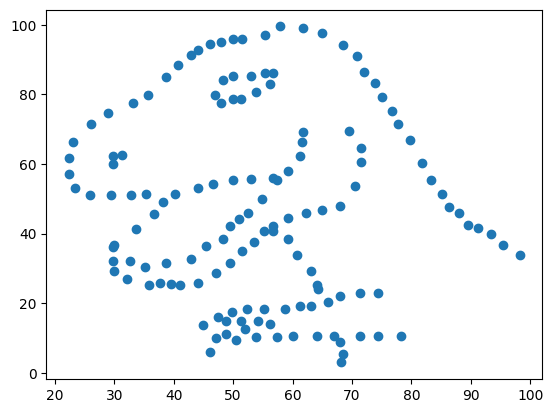

In [ ]:
df = pd.read_csv('tiny_diffusion.tsv',sep='\t')
datasaurus = np.asarray(df[df['dataset']== select_object][['x','y']].values, dtype=float).reshape(-1,2)
plt.scatter(datasaurus[:,0],datasaurus[:,1])

### Visualize forward noising process

Next, let's visualize how our dataset looks like when it's noised over 50 steps according to a schedule that
takes us to ~70% of pure noise

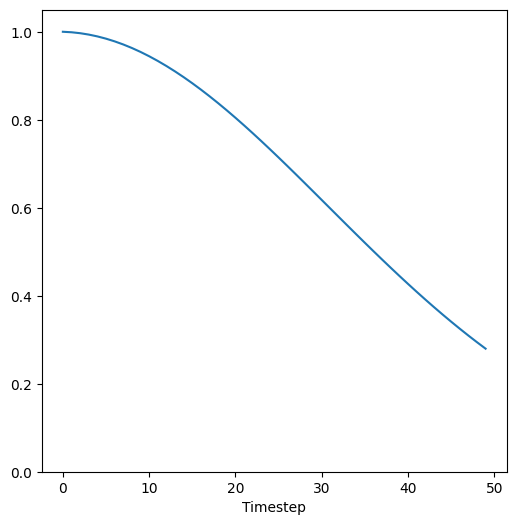

In [ ]:
# Visualize our noising schedule by seeing what the blending parameter alpha_bar looks like
alpha_min = 0.95
alpha_max = 0.9999
T = 50
alpha = torch.linspace(alpha_max, alpha_min, T)
alpha_bar = torch.cumprod(alpha, dim=-1).reshape(-1,1)
plt.figure(figsize=[6, 6])
plt.plot(torch.arange(T), alpha_bar)
plt.xlabel('Timestep')
plt.ylim(0,1.05)
plt.savefig("alpha_bar_original.svg")
plt.show()
plt.close()

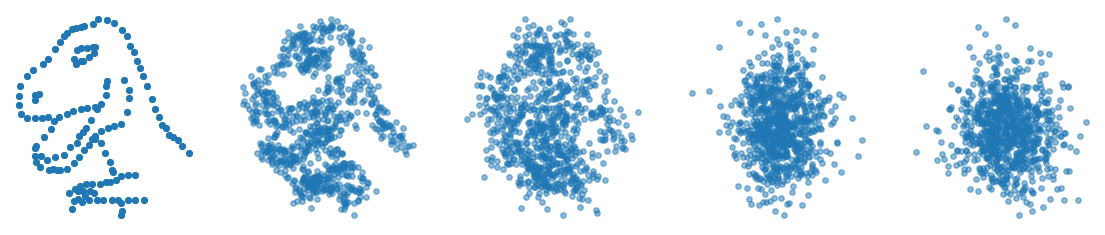

In [ ]:
def forward_noise_dataset(dataset, n_steps=1000, beta_min=0.0001, beta_max=0.02):
    # variance schedule, linearly increasing with timestep
    beta = torch.linspace(beta_min, beta_max, n_steps)
    alpha = 1. - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    s=dataset
    series=[s]
    for t in range(n_steps):
        noise = torch.randn_like(dataset)
        series.append(series[-1]*alpha_bar[t].sqrt() + (1.-alpha[t]).sqrt()*noise)
    return series

datasaurus_tensor = torch.tensor(datasaurus)
datasaurus_tensor = (datasaurus_tensor - datasaurus_tensor.mean())/datasaurus_tensor.std()
trex_viz_input = torch.cat(
    (datasaurus_tensor, datasaurus_tensor, datasaurus_tensor, datasaurus_tensor, datasaurus_tensor, datasaurus_tensor),
    dim=0
)
datasaurus_series = forward_noise_dataset(trex_viz_input, beta_min=(1-0.9999), beta_max=(1-0.95), n_steps=50)
def scatters(cols, rows, datasets, labels, width=14):
    figure = plt.figure(figsize=(width, rows/cols*width))
    for i in range(cols * rows):
        dataset, label = datasets[i], labels[i]
        figure.add_subplot(rows, cols, i+1)
        plt.title(label)
        plt.axis("off")
        plt.scatter(dataset[:,0], dataset[:,1],s=15,alpha=0.5)
    plt.show()

trex_viz_path = Path("trex_viz")
trex_viz_path.mkdir(exist_ok=True)

for i in range(len(datasaurus_series)):
    data = datasaurus_series[i]
    plt.figure(figsize=[6, 6])
    plt.scatter(data[:,0], data[:,1],s=15,alpha=0.5)
    plt.axis('off')
    plt.savefig(trex_viz_path/f"step{i:03d}.svg")
    plt.close()

display_ts = [0, 6, 12, 25, 50]
scatters(len(display_ts), 1, [datasaurus_series[i] for i in display_ts], ["" for _ in range(len(display_ts))])

### Visualize reverse process

For fun, we can visualize the estimated "drift vector" fields, e.g. the expected direction that a noisy point came from in the previous timestep. This is what our denoising model will learn.

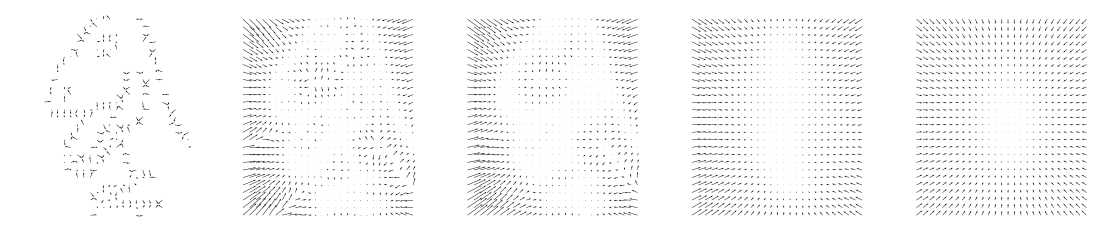

/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.11/dist-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


In [ ]:
def drift_grids(dataset, xrange=(-2,2,0.15), yrange=(-2,2,0.15), n_steps=1000, beta_min=0.0001, beta_max=0.02):
    X,Y=np.meshgrid(np.arange(*xrange),np.arange(*yrange))
    XY=torch.tensor(np.stack((X,Y),axis=-1))
    # variance schedule, linearly increasing with timestep
    beta = torch.linspace(beta_min, beta_max, n_steps)
    alpha = 1. - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    dataset_grid = torch.tensor(np.full(XY.shape[:-1] + dataset.shape, dataset))
    s=torch.zeros_like(XY)
    series=[s]
    for t in range(n_steps):
        alpha_bar_t1 = alpha_bar[t-1] if t>0 else torch.tensor(1.)
        xts = XY[:,:,None,:] # [xlen,ylen,1,2]
        x0s = dataset_grid # [xlen,ylen,N,2]
        mus = (alpha[t].sqrt()*(1-alpha_bar_t1)*xts + alpha_bar_t1.sqrt()*(1-alpha[t])*x0s)/(1-alpha_bar[t]) # [xlen,ylen,N,2]
        weights = torch.exp(-(torch.linalg.vector_norm(xts-alpha_bar[t].sqrt()*x0s, ord=2, dim=-1)/(1-alpha_bar[t]))/2) # [xlen,ylen,N]
        weights = weights / torch.sum(weights, dim=2, keepdim=True)
        mus = torch.sum(mus*weights[...,None], dim=2) # [xlen,ylen,2]
        drift = mus - xts.reshape(mus.shape) # [xlen,ylen,2]
        series.append(drift.numpy())
    return series

def quivers(cols, rows, datasets, labels, width=14, xrange=(-2,2,0.15), yrange=(-2,2,0.15)):
    X,Y=np.meshgrid(np.arange(*xrange),np.arange(*yrange))
    figure = plt.figure(figsize=(width, rows/cols*width))
    for i in range(cols * rows):
        dataset, label = datasets[i], labels[i]
        figure.add_subplot(rows, cols, i+1)
        plt.title(label)
        plt.axis("off")
        plt.quiver(X, Y, dataset[:,:,0], dataset[:,:,1])
    plt.show()

xrange=(-2,2,0.15)
yrange=(-2,2,0.15)
datasaurus_drift = drift_grids(datasaurus_tensor, beta_min=(1-0.9999), beta_max=(1-0.95), n_steps=50, xrange=xrange, yrange=yrange)
display_ts = [1, 6, 12, 25, 50]
quivers(len(display_ts), 1, [datasaurus_drift[i] for i in display_ts], ["" for _ in range(len(display_ts))], xrange=xrange, yrange=yrange)

for i in range(len(datasaurus_drift)):
    X,Y=np.meshgrid(np.arange(*xrange),np.arange(*yrange))
    data = datasaurus_drift[i]
    plt.figure(figsize=[6, 6])
    plt.quiver(X, Y, data[:,:,0], data[:,:,1])
    plt.axis('off')
    plt.savefig(trex_viz_path/f"drift{i:03d}.svg")
    plt.close()

```
# This is formatted as code
```

## **Training a model**

First, let's define our model, our dataset, and a training helper function.

In [ ]:
from torch.utils.data import DataLoader

class DenoisingMLP(torch.nn.Module):
    def __init__(self, device, T, input_embedding='fourier', time_embedding='fourier'):
        super().__init__()
        self.T = T
        self.input_embedding = input_embedding
        if input_embedding == 'fourier':
            self.input_L = 64
            self.input_B = torch.randn((self.input_L//2,2)).to(device)
        elif input_embedding == 'identity':
            self.input_L = 2
        else:
            raise Exception("unknown input embedding")
        self.time_embedding = time_embedding
        if time_embedding == 'fourier':
            self.time_L = 32
            self.time_B = torch.randn((self.time_L//2,1)).to(device)
        elif time_embedding == 'linear':
            self.time_L = 1
        elif time_embedding == 'zero':
            self.time_L = 0
        else:
            raise Exception("unknown time embedding")
        nh = 64
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_L + self.time_L, nh),
            torch.nn.ReLU(),
            torch.nn.Linear(nh, nh),
            torch.nn.ReLU(),
            torch.nn.Linear(nh, nh),
            torch.nn.ReLU(),
            torch.nn.Linear(nh, nh),
            torch.nn.ReLU(),
            torch.nn.Linear(nh, 2),
        ).to(device)

    def forward(self, xt, t):
        if xt.shape[0] != t.shape[0]:
            raise Exception("expect t.shape[0]==xt.shape[0]")
        if self.input_embedding == 'fourier':
            xt = (self.input_B @ xt.T).T
            xt = torch.cat((torch.sin(xt), torch.cos(xt)), dim=1)
        if self.time_embedding == 'fourier':
            t = t / self.T - 0.5
            t = (self.time_B @ t[...,None].T).T
            t = torch.cat((torch.sin(t), torch.cos(t)), dim=1)
        elif self.time_embedding == 'linear':
            t = t[...,None] / self.T - 0.5
        x=torch.cat((xt, t.reshape(-1, self.time_L)), dim=1) if self.time_L > 0 else xt
        return self.layers(x)

def train(model, train_dataloader, test_dataloader, alpha_min=0.94, alpha_max=0.999, T=200, n_epochs=50, lr=4e-3, device='cpu'):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    alpha = torch.linspace(alpha_max, alpha_min, T, device=device)
    alpha_bar = torch.cumprod(alpha, dim=-1).reshape(-1,1)
    losses = []
    for e in range(n_epochs):
        model.train()
        for x0s in train_dataloader:
            x0s = x0s[0]
            eps = torch.randn_like(x0s)
            t = torch.randint(T, (x0s.shape[0],), device=device)
            xts = alpha_bar[t].sqrt()*x0s + (1.-alpha_bar[t]).sqrt()*eps
            eps_pred = model(xts, t)
            loss = torch.nn.functional.mse_loss(eps_pred, eps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            test_batch_losses = []
            test_batch_sizes = []
            for x0s in test_dataloader:
                x0s = x0s[0]
                eps = torch.randn_like(x0s)
                t = torch.randint(T, (x0s.shape[0],), device=device)
                xts = alpha_bar[t].sqrt()*x0s +  (1.-alpha_bar[t]).sqrt()*eps
                eps_pred = model(xts, t)
                loss = torch.nn.functional.mse_loss(eps_pred, eps)
                test_batch_losses.append(loss.item()*x0s.shape[0])
                test_batch_sizes.append(x0s.shape[0])
            smoothed_loss = sum(test_batch_losses) / sum(test_batch_sizes)
            if e > 0:
                smoothed_loss = smoothed_loss*0.01 + losses[-1]*0.99
            losses.append(smoothed_loss)
    plt.plot(np.arange(n_epochs), losses)
    plt.show()

torch.manual_seed(42)
device = 'cpu'
idxs = torch.randperm(trex_viz_input.shape[0]).long()
num_train_data = int(idxs.shape[0]*0.9)
train_data = torch.utils.data.TensorDataset(trex_viz_input[idxs[:num_train_data]].float().to(device))
test_data = torch.utils.data.TensorDataset(trex_viz_input[idxs[num_train_data:]].float().to(device))
bs = 32
train_dataloader = DataLoader(train_data, bs, shuffle=True)
test_dataloader = DataLoader(test_data, bs, shuffle=True)

### Attempt 1
- Identity embeddings for position
- Zero embeddings for time (e.g. no time input)

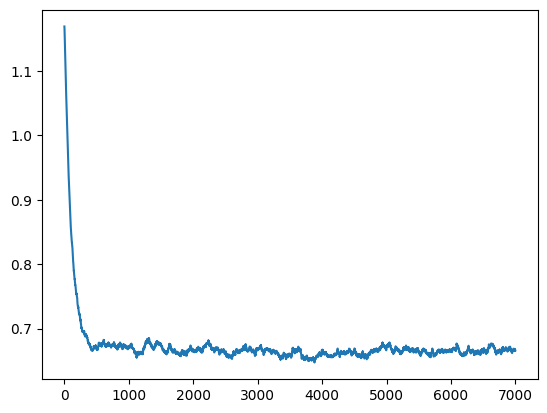

CPU times: user 8min 13s, sys: 907 ms, total: 8min 14s
Wall time: 8min 20s


In [ ]:
%%time
mlp1 = DenoisingMLP('cpu', T, 'identity', 'zero')
train(mlp1, train_dataloader, test_dataloader, alpha_min=alpha_min, alpha_max=alpha_max, T=T, lr=4e-4, n_epochs=7000)

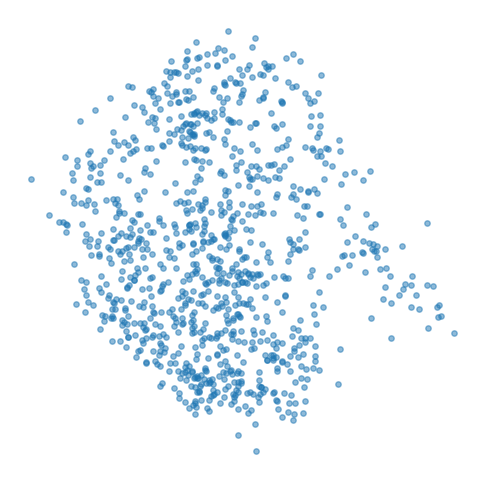

In [ ]:
@torch.no_grad()
def sample(num_samples, model, alpha_min=0.94, alpha_max=0.999, T=200, device='cpu'):
    alpha = torch.linspace(alpha_max, alpha_min, T).to(device)
    alpha_bar = torch.cumprod(alpha, dim=-1).reshape(-1,1)
    steps = []
    xt = torch.randn((num_samples, 2)).to(device)
    for t in reversed(range(T)):
        t_batch = torch.full((num_samples,), t).to(device)
        noise_pred = model(xt, t_batch)
        mu_hat_t = (xt - (1-alpha[t])/(1-alpha_bar[t]).sqrt()*noise_pred)/(alpha[t]).sqrt()

        z = torch.randn_like(xt).to(device)
        sigma = (1.-alpha[t]).sqrt()
        xt = mu_hat_t + sigma*z
        steps.append(xt.clone().detach().to('cpu'))
    return steps

steps = sample(1000, mlp1, alpha_min=alpha_min, alpha_max=alpha_max, T=T)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp1.svg")
plt.show()
plt.close()

**Observation**: The drift fields at higher timesteps look very different than drift fields at lower timesteps. Let's try supplying timestep info to our neural network.

### Attempt 2
- Identity embeddings for position
- Linear embeddings for time

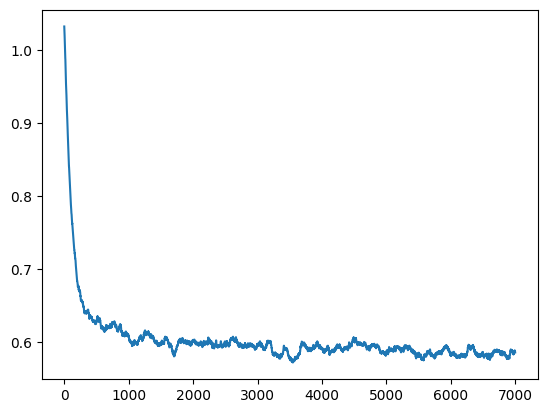

CPU times: user 8min 37s, sys: 980 ms, total: 8min 38s
Wall time: 8min 41s


In [ ]:
%%time
mlp2 = DenoisingMLP('cpu', T, 'fourier', 'linear')
train(mlp2, train_dataloader, test_dataloader, alpha_min=alpha_min, alpha_max=alpha_max, T=T, lr=4e-4, n_epochs=7000)

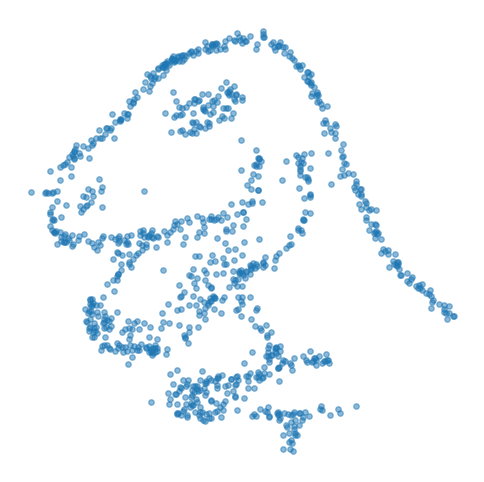

In [ ]:
torch.manual_seed(42)
steps = sample(1000, mlp2, alpha_min=alpha_min, alpha_max=alpha_max, T=T)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp2.svg")
plt.show()
plt.close()

It's known that fourier embeddings help neural networks learn 2D mappings more easily, see *Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains* (Tancik 2020).

### Attempt 3
- Fourier embeddings for position
- Fourier embeddings for time

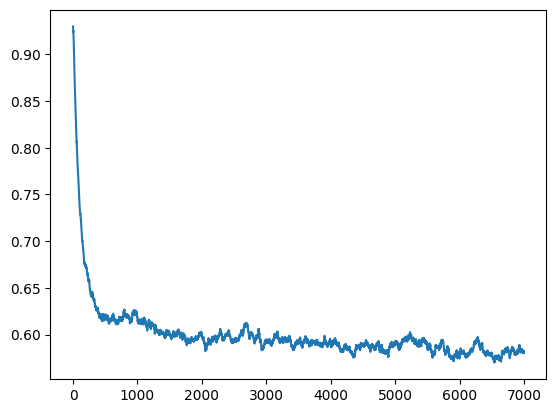

CPU times: user 8min 48s, sys: 982 ms, total: 8min 49s
Wall time: 8min 53s


In [ ]:
%%time
mlp3 = DenoisingMLP('cpu', T, 'fourier', 'fourier')
train(mlp3, train_dataloader, test_dataloader, alpha_min=alpha_min, alpha_max=alpha_max, T=T, lr=4e-4, n_epochs=7000)

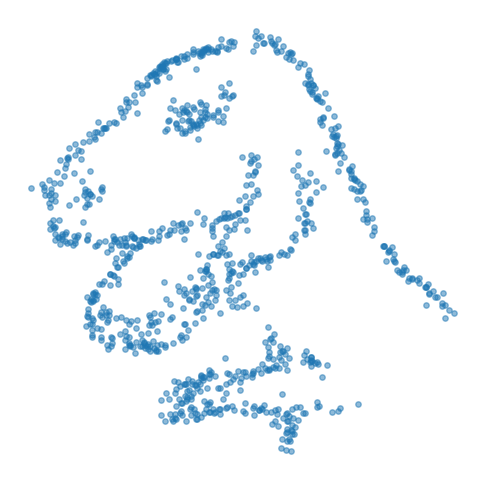

In [ ]:
torch.manual_seed(42)
steps = sample(1000, mlp3, alpha_min=alpha_min, alpha_max=alpha_max, T=T)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp3.svg")
plt.show()
plt.close()

**Observation**: Everything after step 25 of our 50 noising steps pretty much looks like pure noise. Maybe we should spend more time trying to learn the earlier steps where there is more signal.

### Attempt 4
- Fourier embeddings for position
- Fourier embeddings for time
- Modified noise schedule that spends more time in higher-signal regimes

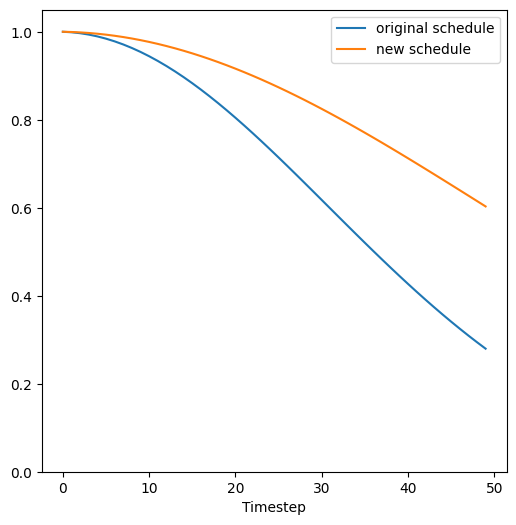

In [ ]:
# Let's construct a noising schedule which takes the alpha_bar that our old schedule had around step 25,
# then stretches the schedule so that we end up with that same value at step 50

old_alpha_min = 0.95
old_alpha_max = 0.9999
T = 50
old_alpha = torch.linspace(old_alpha_max, old_alpha_min, T)
old_alpha_bar = torch.cumprod(old_alpha, dim=-1).reshape(-1,1)

alpha_min = 0.98
alpha_max = 0.9999
new_alpha = torch.linspace(alpha_max, alpha_min, T)
alpha_bar = torch.cumprod(new_alpha, dim=-1).reshape(-1,1)
plt.figure(figsize=[6, 6])
plt.plot(torch.arange(T), old_alpha_bar, label="original schedule")
plt.plot(torch.arange(T), alpha_bar, label="new schedule")
plt.legend()
plt.xlabel('Timestep')
plt.ylim(0,1.05)
plt.savefig(trex_viz_path/f"alpha_bar_modified.svg")
plt.show()
plt.close()

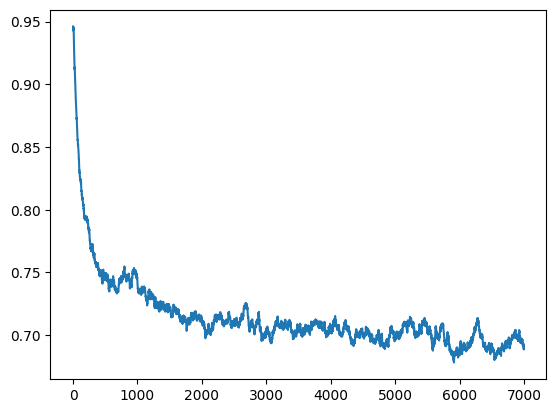

CPU times: user 8min 47s, sys: 988 ms, total: 8min 48s
Wall time: 8min 52s


In [ ]:
%%time
mlp4 = DenoisingMLP('cpu', T, 'fourier', 'fourier')
train(mlp4, train_dataloader, test_dataloader, alpha_min=alpha_min, alpha_max=alpha_max, T=T, lr=4e-4, n_epochs=7000)

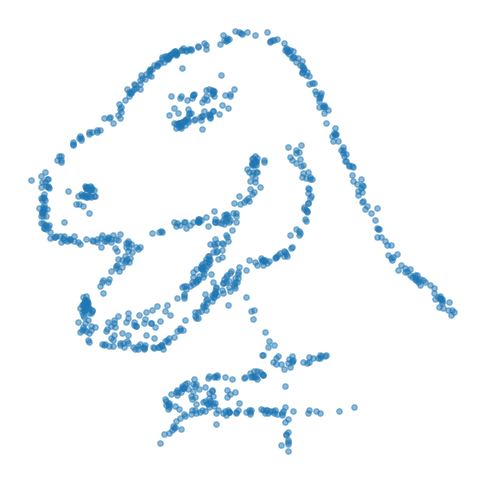

In [ ]:
torch.manual_seed(42)
steps = sample(1000, mlp4, alpha_min=alpha_min, alpha_max=alpha_max, T=T)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp4.svg")
plt.show()
plt.close()